<a href="https://colab.research.google.com/github/quanvu0996/compet/blob/master/Kaggle_compet/WiDS_2021/WiDS_2021_LGBM_version_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#from catboost import Pool, cv, CatBoostClassifier, CatBoostRegressor

from sklearn.metrics import mean_squared_error, classification_report
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
import lightgbm as lgb

# import xgboost
# import lightgbm as lgb
# from lightgbm import LGBMClassifier

import os
# for dirname, _, filenames in os.walk('input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
        
import gc
import matplotlib.pyplot as plt
# import seaborn as sns

from sklearn import metrics
pd.set_option('max_rows', 500)
import re

import os
# for dirname, _, filenames in os.walk('/Competition/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# pd.set_option('display.max_columns', 1000)
# np.random.seed(566)
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', '{:20,.2f}'.format)
# # pd.set_option('display.max_colwidth', -1)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load train/test data
* If doing feature engineering, we could combine the 2 dataframes together then split them after. But we'll go for a naive approach in this kernel

In [ ]:
TARGET_COL = "diabetes_mellitus"

In [ ]:
folder_path = '/content/drive/My Drive/Colab Notebooks/WiDS2021/'
input_path = folder_path #'../input/dictfeats/'

df = pd.read_csv(folder_path +'TrainingWiDS2021.csv')

df.shape

test = pd.read_csv(folder_path +'UnlabeledWiDS2021.csv')

test.shape
print(df.shape)
display(df.nunique())


(130157, 181)


Unnamed: 0                     130157
encounter_id                   130157
hospital_id                       204
age                                75
bmi                             41453
elective_surgery                    2
ethnicity                           6
gender                              2
height                            443
hospital_admit_source              15
icu_admit_source                    5
icu_id                            328
icu_stay_type                       3
icu_type                            8
pre_icu_los_days                10912
readmission_status                  1
weight                           3636
albumin_apache                     36
apache_2_diagnosis                 44
apache_3j_diagnosis               400
apache_post_operative               2
arf_apache                          2
bilirubin_apache                  585
bun_apache                        476
creatinine_apache                1198
fio2_apache                        87
gcs_eyes_apa

In [ ]:
#Merge train vs test
df_full=pd.concat([df,test])


## **EDA**

---


**Check total number items in each class.**

In [ ]:
print(df[TARGET_COL].value_counts())
print (len(df[df[TARGET_COL]==1])/len(df))


0    102006
1     28151
Name: diabetes_mellitus, dtype: int64
0.21628494817796967


Check number of NA in each column

In [ ]:
display(((df.isna().sum()/len(df))*100))


In [ ]:
# List Cols which have the number of NA values <= 20%
na_20cols=[c for c in df.columns if (((df[c].isna().sum()/len(df))*100) <= 20)]

# List Cols which have the number of NA values 20% <= 50%
na_2050cols=[c for c in df.columns if ((((df[c].isna().sum()/len(df))*100) > 20) and (((df[c].isna().sum()/len(df))*100) <= 50))]

# List Cols which have the number of NA values 50% <= 90%
na_5090cols=[c for c in df.columns if ((((df[c].isna().sum()/len(df))*100) > 50) and (((df[c].isna().sum()/len(df))*100) < 90))]

# List Cols which have the number of NA values 20% <= 50%
na_90cols=[c for c in df.columns if (((df[c].isna().sum()/len(df))*100) >= 90)]



In [ ]:
print(len(na_20cols))
print(len(na_2050cols))
print(len(na_5090cols))
print(len(na_90cols))

In [ ]:
na_90cols

In [ ]:
na_5090cols.append(TARGET_COL)
na_2050cols.append(TARGET_COL)
na_20cols.append(TARGET_COL)
na_5090cols

In [ ]:
corr_20cols = df[na_20cols].corr()

corr_2050cols = df[na_2050cols].corr()

corr_5090cols = df[na_5090cols].corr()

In [ ]:
print(corr_2050cols[TARGET_COL].sort_values(ascending=False))

In [ ]:

print(corr_5090cols[TARGET_COL].sort_values(ascending=False))

In [ ]:
# corr[TARGET_COL]

print(corr_20cols[TARGET_COL].sort_values(ascending=False))

In [ ]:
print(na_2050cols)

['hospital_admit_source', 'hematocrit_apache', 'urineoutput_apache', 'wbc_apache', 'h1_temp_max', 'h1_temp_min']


In [ ]:
display(((df[na_20cols].isna().sum()/len(df))*100))

In [ ]:
df.describe()

In [ ]:
#fig, ax = plt.subplots(figsize=(20, 10))
#fig, axes = plt.subplots(3,3)
sns.displot(data=df,x="d1_glucose_max",hue=TARGET_COL,bins=20,aspect=1)   
sns.displot(data=df, x="d1_glucose_min",hue=TARGET_COL,bins=20,aspect=1)    
sns.displot(data=df, x="h1_glucose_max",hue=TARGET_COL,bins=20,aspect=1)    
sns.displot(data=df, x="h1_glucose_min",hue=TARGET_COL,bins=20,aspect=1) 
sns.displot(data=df, x="glucose_apache",hue=TARGET_COL,bins=20,aspect=1) 

In [ ]:
print(df[df["d1_glucose_max"].isnull()].groupby(TARGET_COL)["encounter_id"].count())
print(df[df["d1_glucose_min"].isnull()].groupby(TARGET_COL)["encounter_id"].count())
print(df[df["h1_glucose_max"].isnull()].groupby(TARGET_COL)["encounter_id"].count())
print(df[df["h1_glucose_min"].isnull()].groupby(TARGET_COL)["encounter_id"].count())
print(df[df["glucose_apache"].isnull()].groupby(TARGET_COL)["encounter_id"].count())

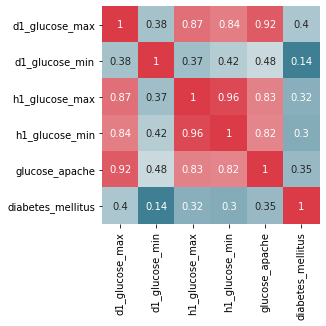

In [ ]:
glucose_cols=["d1_glucose_max","d1_glucose_min","h1_glucose_max","h1_glucose_min","glucose_apache",TARGET_COL]
corr_glucose=df[glucose_cols].corr()
sns.heatmap(corr_glucose, mask=np.zeros_like(corr_glucose, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, cbar=False,annot=True)

In [ ]:
df[glucose_cols].describe()

,d1_glucose_max,d1_glucose_min,h1_glucose_max,h1_glucose_min,glucose_apache,diabetes_mellitus
count,121914.000000,121914.000000,55084.000000,55084.000000,115461.000000,130157.000000
mean,174.149802,114.440310,167.702625,158.908794,160.141416,0.216285
std,86.545466,38.217682,94.033461,88.298827,90.701327,0.411712
min,73.000000,33.000000,59.000000,42.000000,39.000000,0.000000
25%,117.000000,91.000000,111.000000,106.000000,97.000000,0.000000
50%,150.000000,108.000000,140.000000,134.000000,133.000000,0.000000
75%,200.000000,131.000000,189.000000,179.000000,195.000000,0.000000
max,611.000000,288.000000,695.045000,670.000000,598.700000,1.000000


In [ ]:
features_models=["d1_glucose_max","d1_glucose_min","h1_glucose_max","h1_glucose_min","glucose_apache"]

**Process difference between readings of patients**

In [ ]:
lab_col_names =  ['pao2fio2ratio', 'wbc', 'arterial_ph', 'bilirubin',
  'glucose', 'mbp_noninvasive', 'calcium', 'spo2', 'inr', 'platelets', 'hco3',
  'creatinine', 'sysbp_invasive', 'mbp_invasive', 'resprate', 'temp', 'sysbp',
  'sysbp_noninvasive', 'heartrate', 'sodium', 'diasbp_invasive', 'bun', 'arterial_po2',
  'lactate', 'hematocrit', 'diasbp_noninvasive',
  'mbp', 'albumin', 'arterial_pco2', 'diasbp', 'hemaglobin', 'potassium']
first_h = []
for v in lab_col_names:
    h1_idx_min='h1_'+v+'_min'
    h1_idx_max='h1_'+v+'_max'
    d1_idx_min='d1_'+v+'_min'
    d1_idx_max='d1_'+v+'_max'
    df_full.loc[df_full[d1_idx_min]> df[d1_idx_min],d1_idx_max] = df_full.loc[df_full[d1_idx_min]> df[d1_idx_min],d1_idx_min]

ValueError: ignored

In [ ]:
d_cols = [c for c in df_full.columns if(c.startswith("d1"))]
h_cols = [c for c in df_full.columns if(c.startswith("h1"))]

df_full["dailyLabs_row_nan_count"] = df_full[d_cols].isna().sum(axis=1)
df_full["hourlyLabs_row_nan_count"] = df_full[h_cols].isna().sum(axis=1)

df_full["diff_labTestsRun_daily_hourly"] = df_full["dailyLabs_row_nan_count"] - df_full["hourlyLabs_row_nan_count"]

features_models.append('dailyLabs_row_nan_count')
features_models.append('hourlyLabs_row_nan_count')
features_models.append('diff_labTestsRun_daily_hourly')
#tiếp tục refer top 1 notebook để tạo thêm feature

In [ ]:
lab_col_names =  ['pao2fio2ratio', 'wbc', 'arterial_ph', 'bilirubin',
  'glucose', 'mbp_noninvasive', 'calcium', 'spo2', 'inr', 'platelets', 'hco3',
  'creatinine', 'sysbp_invasive', 'mbp_invasive', 'resprate', 'temp', 'sysbp',
  'sysbp_noninvasive', 'heartrate', 'sodium', 'diasbp_invasive', 'bun', 'arterial_po2',
  'lactate', 'hematocrit', 'diasbp_noninvasive',
  'mbp', 'albumin', 'arterial_pco2', 'diasbp', 'hemaglobin', 'potassium']
first_h = []
df_1=df[df[TARGET_COL]==1]
df_0=df[df[TARGET_COL]==0]
for v in lab_col_names:
    h1_idx_min='h1_'+v+'_min'
    h1_idx_max='h1_'+v+'_max'
    d1_idx_min='d1_'+v+'_min'
    d1_idx_max='d1_'+v+'_max'
    mean_h1_min_1=df_1[h1_idx_min].mean()
    mean_d1_min_1=df_1[d1_idx_min].mean()
    mean_h1_max_1=df_1[h1_idx_max].mean()
    mean_d1_max_1=df_1[d1_idx_max].mean()
    mean_h1_min_0=df_0[h1_idx_min].mean()
    mean_d1_min_0=df_0[d1_idx_min].mean()
    mean_h1_max_0=df_0[h1_idx_max].mean()
    mean_d1_max_0=df_0[d1_idx_max].mean()
    dis_h1_min_0= 'h1_min_'+idx+'_dis_0'
    dis_d1_min_0= 'd1_min_'+idx+'_dis_0'
    dis_h1_min_1= 'h1_min_'+idx+'_dis_1'
    dis_d1_min_1= 'd1_min_'+idx+'_dis_1'
    dis_h1_max_0= 'h1_max_'+idx+'_dis_0'
    dis_d1_max_0= 'd1_max_'+idx+'_dis_0'
    dis_h1_max_1= 'h1_max_'+idx+'_dis_1'
    dis_d1_max_1= 'd1_max_'+idx+'_dis_1'
    df_full[dis_h1_min_0]=df_full[h1_idx_min]-mean_h1_min_0
    df_full[dis_d1_min_0]=df_full[d1_idx_min]-mean_d1_min_0
    df_full[dis_h1_min_1]=df_full[h1_idx_min]-mean_h1_min_1
    df_full[dis_d1_min_1]=df_full[d1_idx_min]-mean_d1_min_1
    df_full[dis_h1_max_0]=df_full[h1_idx_max]-mean_h1_max_0
    df_full[dis_d1_max_0]=df_full[d1_idx_max]-mean_d1_max_0
    df_full[dis_h1_max_1]=df_full[h1_idx_max]-mean_h1_max_1
    df_full[dis_d1_max_1]=df_full[d1_idx_max]-mean_d1_max_1
    df_full[v+"_d1_value_range"] = df_full[f"d1_{v}_max"].subtract(df_full[f"d1_{v}_min"])
    features_models.append(v+"_d1_value_range")
    df_full[v+"_h1_value_range"] = df_full[f"h1_{v}_max"].subtract(df_full[f"h1_{v}_min"])
#     df_full[v+"_h1_value_range_normalized"] = df_full[f"h1_{v}_max"].subtract(df_full[f"h1_{v}_min"]).div(df_full[f"h1_{v}_max"])
    features_models.append(v+"_h1_value_range")
    # daily change in value range - hour vs day. could do subtract or div here.. 
    df_full[v+"_tot_change_value_range_normed"] = abs((df_full[v+"_d1_value_range"].div(df_full[v+"_h1_value_range"])))#.div(df_full[f"d1_{v}_max"]))
    features_models.append(v+"_tot_change_value_range_normed")
    # Cases where there's no reading in the first hour, but only  later in day ?
    df_full[v+"_started_after_firstHour"] = ((df_full[f"h1_{v}_max"].isna()) & (df_full[f"h1_{v}_min"].isna())) & (~df_full[f"d1_{v}_max"].isna())
    features_models.append(v+"_started_after_firstHour")
    first_h.append(v+"_started_after_firstHour")
    list_cols=[f"d1_{v}_max",f"d1_{v}_min",f"h1_{v}_max",f"h1_{v}_min"]
    df_full[v+"_std"]=df_full[list_cols].std(axis=1)

    ## Did a reading get more extreme after the first hour. 
    ## This misses cases where the readying is in an unhealthy region and "improves"!!
    df_full[v+"_day_more_extreme"] = ((df_full[f"d1_{v}_max"]>df_full[f"h1_{v}_max"]) | (df_full[f"d1_{v}_min"]<df_full[f"h1_{v}_min"]))
    df_full[v+"_day_more_extreme"].fillna(False)

df_full["total_Tests_started_After_firstHour"] = df_full[first_h].sum(axis=1)
more_extreme_cols = [c for c in df_full.columns if(c.endswith("_day_more_extreme"))]

df_full["total_day_more_extreme"] = df_full[more_extreme_cols].sum(axis=1)


In [ ]:
df_full['NA_info']=df_full[df_full.columns].isna().sum(axis=1)
features_models.append('NA_info')

**Process "glucose" feats**

In [ ]:
glu_map = {}
for n in range(0,10):
    start=n*30
    end=(n+1)*30
    count=df.loc[((df["d1_glucose_max"]>start)& (df["d1_glucose_max"]<=end)),"d1_glucose_max"].count()
    count_1=df.loc[((df["d1_glucose_max"]>start) & (df["d1_glucose_max"]<=end) & (df[TARGET_COL]==1)),"d1_glucose_max"].count()
    glu_map[n]=(count_1/count)
glu_map[10]=(df.loc[((df["d1_glucose_max"]>300)),"d1_glucose_max"].count())/(df.loc[((df["d1_glucose_max"]>300) & (df[TARGET_COL]==1)),"d1_glucose_max"].count())
glu_map[0]=0
glu_map[0]=0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


In [ ]:
glu_map

{0: 0,
 1: nan,
 2: 0.04770375161707632,
 3: 0.05922098569157393,
 4: 0.11576867816091954,
 5: 0.20434401480471412,
 6: 0.319634703196347,
 7: 0.42674595141700405,
 8: 0.5137128806506526,
 9: 0.5549933422103861,
 10: 1.663129973474801}

In [ ]:
def glucose_prob(x):
    n=x//50
    if n > 10:
        n=10
    return glu_map[n]

In [ ]:
 #count number of glucose NA
glucose_d=["d1_glucose_max","d1_glucose_min"]
glucose_h=["h1_glucose_max","h1_glucose_min"]
glucose_columns = ["d1_glucose_max","d1_glucose_min","h1_glucose_max","h1_glucose_min"]
df_full["glucose_na_h"] = df_full[glucose_h].isna().sum(axis=1)
df_full["glucose_na_d"] = df_full[glucose_d].isna().sum(axis=1)
df_full["glucose_na"] = df_full["glucose_na_h"] + df_full["glucose_na_d"]

features_models =features_models + ["glucose_na_h","glucose_na_d","glucose_na"]

 #fillNA
df_full.loc[df_full["d1_glucose_max"].isna() & (df_full["glucose_apache"].notna()),"d1_glucose_max"]=df_full.loc[df_full["d1_glucose_max"].isna() & (df_full["glucose_apache"].notna()),"glucose_apache"]
df_full['d1_glucose_max']=df_full['d1_glucose_max'].fillna(0)
df_full['d1_glucose_min']=df_full['d1_glucose_min'].fillna(0)
df_full.loc[df_full["h1_glucose_min"].isna() & (df_full["d1_glucose_min"].notna()),"h1_glucose_min"]=df_full.loc[df_full["h1_glucose_min"].isna() & (df_full["d1_glucose_min"].notna()),"d1_glucose_min"]
df_full.loc[df_full["h1_glucose_max"].isna() & (df_full["d1_glucose_max"].notna()),"h1_glucose_min"]=df_full.loc[df_full["h1_glucose_max"].isna() & (df_full["d1_glucose_max"].notna()),"d1_glucose_max"]
df_full['h1_glucose_min']=df_full['h1_glucose_min'].fillna(0)
df_full['h1_glucose_max']=df_full['h1_glucose_max'].fillna(0)

# Create new feature
df_full['glucose_max_min_d']= df_full['d1_glucose_max']-df_full['d1_glucose_min']
df_full['glucose_max_min_h']= df_full['h1_glucose_max']-df_full['h1_glucose_min']
df_full['glucose_d_h'] = df_full['d1_glucose_max']-df_full['h1_glucose_max']

df_full['d_max_glucose_risk_200']=0
df_full.loc[df_full["d1_glucose_max"]>=200,"d_max_glucose_risk_200"]=1
df_full['d_max_glucose_risk_140']=0
df_full.loc[df_full["d1_glucose_max"]>=140,"d_max_glucose_risk_140"]=1

df_full['d_min_glucose_risk_200']=0
df_full.loc[df_full["d1_glucose_min"]>=200,"d_min_glucose_risk_200"]=1
df_full['d_min_glucose_risk_140']=0
df_full.loc[df_full["d1_glucose_min"]>=140,"d_min_glucose_risk_140"]=1


df_full['h_max_glucose_risk_200']=0
df_full.loc[df_full["h1_glucose_max"]>=200,"h_max_glucose_risk_200"]=1
df_full['h_max_glucose_risk_140']=0
df_full.loc[df_full["h1_glucose_max"]>=140,"h_max_glucose_risk_140"]=1

df_full['h_min_glucose_risk_200']=0
df_full.loc[df_full["h1_glucose_min"]>=200,"h_min_glucose_risk_200"]=1
df_full['h_min_glucose_risk_140']=0
df_full.loc[df_full["h1_glucose_min"]>=140,"h_min_glucose_risk_140"]=1

df_full['glu_risk_200']= df_full['d_max_glucose_risk_200'] + df_full['d_min_glucose_risk_200'] + df_full['h_max_glucose_risk_200'] + df_full['h_min_glucose_risk_200']

df_full['glu_risk_140']= df_full['d_max_glucose_risk_140'] + df_full['d_min_glucose_risk_140'] + df_full['h_max_glucose_risk_140'] + df_full['h_min_glucose_risk_140']


mean_glucose_1=df.loc[df[TARGET_COL]==1,'d1_glucose_max'].mean()
mean_glucose_0=df.loc[df[TARGET_COL]==0,'d1_glucose_max'].mean()

std_glucose_1=df.loc[df[TARGET_COL]==1,'d1_glucose_max'].std()
std_glucose_0=df.loc[df[TARGET_COL]==0,'d1_glucose_max'].std()
df_full['glucose_max_mean_1']=df_full['d1_glucose_max']-mean_glucose_1
df_full['glucose_max_mean_0']=df_full['d1_glucose_max']-mean_glucose_0

df_full['glucose_max_std_1']=(df_full['d1_glucose_max']-mean_glucose_1)/std_glucose_1
df_full['glucose_max_std_0']=(df_full['d1_glucose_max']-mean_glucose_1)/std_glucose_0

df_full['glucose_prob']=df_full['d1_glucose_max'].map(glucose_prob)

df_full['glucose_std']= df_full[glucose_columns].std(axis=1)

features_models=features_models+["glucose_max_min_d","glucose_max_min_h","glucose_d_h","glucose_risk_200","glucose_risk_140"
                                  ,'glucose_max_mean_1','glucose_max_mean_0','glucose_max_std_1','glucose_max_std_0','glucose_prob']
features_models.append("glucose_std")


**Process AGE,BMI,WEIGHT** 

In [ ]:
print(df[df["age"].isnull()].groupby(TARGET_COL)["encounter_id"].count())
df_full["age"].describe()

diabetes_mellitus
0    4328
1     660
Name: encounter_id, dtype: int64


count    135403.000000
mean         62.059991
std          16.904279
min           0.000000
25%          52.000000
50%          64.000000
75%          75.000000
max          96.000000
Name: age, dtype: float64

In [ ]:
def weightedclasst(x):
    """based on : https://www.kaggle.com/c/widsdatathon2020/discussion/127987 but made to use ordinals"""
    if pd.isna(x):
        return np.nan
    if x < 15: return 0 
    elif x >= 15 and x < 16: return 1
    elif x >=16 and x < 18.5: return 2 
    elif x >= 18.5 and x < 25: return 3 
    elif x >= 25 and x < 30: return 4 
    elif x >= 30 and x < 35: return 5 
    elif x >= 35: return 6

In [ ]:
df["diff_bmi"] = df['bmi'].copy() # orig BMI values
df['bmi'] = df['weight']/((df['height']/100)**2)
df["diff_bmi"] = df["diff_bmi"]-df['bmi']
df_full['weightclass'] = df_full['bmi'].map(weightedclasst)
# df_full['bmi'].fillna(df_full['bmi'].mean())
# df_full['weightclass'].fillna(1)
print(df_full['weightclass'].value_counts())
features_models.append("weightclass")
features_models.append("bmi")
features_models.append("diff_bmi")

4.0    39972
3.0    39529
5.0    25109
6.0    24579
2.0     4303
0.0      749
1.0      645
Name: weightclass, dtype: int64


In [ ]:
df_full['age'].describe()

count    135403.000000
mean         62.059991
std          16.904279
min           0.000000
25%          52.000000
50%          64.000000
75%          75.000000
max          96.000000
Name: age, dtype: float64

In [ ]:
def ageclasst(x):
    if pd.isna(x):
        return np.nan
    if x < 15: return 0 
    elif x >= 15 and x < 25: return 1
    elif x >=25 and x < 35: return 2 
    elif x >= 35 and x < 35: return 3 
    elif x >= 35 and x < 45: return 4 
    elif x >= 45 and x < 55: return 5 
    elif x >= 55 and x < 65: return 6
    elif x >= 65 and x < 75: return 7
    elif x >= 75: return 8

In [ ]:
df_full['ageclass'] = df_full['age'].map(ageclasst)
# df_full['age'].fillna(0)
# df_full['ageclass'].fillna(0)
print(df_full['ageclass'].value_counts())
features_models.append("ageclass")
features_models.append("age")

8.0    35435
7.0    31577
6.0    28459
5.0    18958
4.0     9560
2.0     7155
1.0     4229
0.0       30
Name: ageclass, dtype: int64


**Process URE - BUN, CREATININE**

In [ ]:
df_full['d1_bun_max'].describe()

count    125549.000000
mean         25.535824
std          20.484652
min           4.000000
25%          13.000000
50%          19.000000
75%          31.000000
max         130.000000
Name: d1_bun_max, dtype: float64

In [ ]:
sns.displot(data=df,x="d1_bun_max",hue=TARGET_COL,bins=20,aspect=1)   
sns.displot(data=df,x="d1_creatinine_max",hue=TARGET_COL,bins=20,aspect=1)   

In [ ]:
def bunclasst(x):
    if pd.isna(x):
        return np.nan
    x=x*0.357
    if x < 7: return 0 
    elif x >= 7 and x < 20: return 1
    elif x >=20 and x < 25: return 2 
    elif x >= 25 and x < 35: return 3
    elif x >= 35: return 4

In [ ]:
bun_d=["d1_bun_max","d1_bun_min"]
bun_h=["h1_bun_max","h1_bun_min"]
bun_columns=["d1_bun_max","d1_bun_min","h1_bun_max","h1_bun_min"]
df_full["bun_na_h"] = df_full[bun_h].isna().sum(axis=1)
df_full["bun_na_d"] = df_full[bun_h].isna().sum(axis=1)
df_full["bun_na"] = df_full["bun_na_h"] + df_full["bun_na_d"]

#FillNA
df_full['d1_bun_max']=df_full['d1_bun_max'].fillna(0)
df_full['d1_bun_min']=df_full['d1_bun_min'].fillna(0)
df_full['h1_bun_min']=df_full['h1_bun_min'].fillna(0)
df_full['h1_bun_max']=df_full['h1_bun_max'].fillna(0)

#Create new features
df_full['bun_max_min_d']= df_full['d1_bun_max']-df_full['d1_bun_min']
df_full['bun_max_min_h']= df_full['h1_bun_max']-df_full['h1_bun_min']
df_full['bun_d_h'] = df_full['d1_bun_max']-df_full['h1_bun_max']

df_full['bun_max_class'] = df_full['d1_bun_max'].map(bunclasst)

df_full['bun_min_class'] = df_full['d1_bun_min'].map(bunclasst)

df_full['bun_std']= df_full[bun_columns].std(axis=1)
features_models=features_models + ["bun_na_h","bun_na_d","bun_na",'d1_bun_max',
                       'd1_bun_min','h1_bun_max','h1_bun_min','bun_max_min_d',
                       'bun_max_min_h','bun_d_h','bun_max_class','bun_min_class','bun_std']

In [ ]:
def creatinineclasst(x):
    if pd.isna(x):
        return np.nan
    if x < 1.5: return 0 
    elif x >= 1.5 and x < 3.5: return 1
    elif x >=3.5 and x < 6: return 2 
    elif x >= 6 and x < 10: return 3
    elif x >= 10: return 4

In [ ]:
creatinine_d=["d1_creatinine_max","d1_creatinine_min"]
creatinine_h=["h1_creatinine_max","h1_creatinine_min"]
creatinie_columns=["d1_creatinine_max","d1_creatinine_min","h1_creatinine_max","h1_creatinine_min"]
df_full["creatinine_na_h"] = df_full[creatinine_h].isna().sum(axis=1)
df_full["creatinine_na_d"] = df_full[creatinine_h].isna().sum(axis=1)
df_full["creatinine_na"] = df_full["creatinine_na_h"] + df_full["creatinine_na_d"]

#FillNA
df_full['d1_creatinine_max']=df_full['d1_creatinine_max'].fillna(0)
df_full['d1_creatinine_min']=df_full['d1_creatinine_min'].fillna(0)
df_full['h1_creatinine_min']=df_full['h1_creatinine_min'].fillna(0)
df_full['h1_creatinine_max']=df_full['h1_creatinine_max'].fillna(0)

#Create new features
df_full['creatinine_max_min_d']= df_full['d1_creatinine_max']-df_full['d1_creatinine_min']
df_full['creatinine_max_min_h']= df_full['h1_creatinine_max']-df_full['h1_creatinine_min']
df_full['creatinine_d_h'] = df_full['d1_creatinine_max']-df_full['h1_creatinine_max']

df_full['creatinine_max_class'] = df_full['d1_creatinine_max'].map(creatinineclasst)

df_full['creatinine_min_class'] = df_full['d1_creatinine_min'].map(creatinineclasst)

df_full['creatinine_std']= df_full[creatinie_columns].std(axis=1)

features_models=features_models + ["creatinine_na_h","creatinine_na_d","creatinine_na",'d1_creatinine_max',
                       'd1_creatinine_min','h1_creatinine_max','h1_creatinine_min','creatinine_max_min_d',
                       'creatinine_max_min_h','creatinine_d_h','creatinine_max_class','creatinine_min_class','creatinine_apache']


**Process Categorical feats**

In [ ]:
categorical_cols=['ethnicity','gender','hospital_admit_source','icu_admit_source','icu_stay_type','icu_type','apache_2_diagnosis']
categorical_cols

['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_stay_type',
 'icu_type',
 'apache_2_diagnosis']

In [ ]:
print(df.columns.tolist())

['Unnamed: 0', 'encounter_id', 'hospital_id', 'age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'readmission_status', 'weight', 'albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min',

In [ ]:
df.head()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,...,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113,502.01,0,0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1
1,2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108,203.01,0,0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.45,33.0,...,11.3,11.3,36.9,36.9,1.3,1.3,3.5,3.5,557.0,557.0,4.2,4.2,145.0,145.0,12.7,12.7,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.000000,37.0,37.0,7.45,7.45,51.0,51.0,51.0,51.0,0,0,0,0,0,0,0,1
2,3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,0,95.3,NaN,122,703.03,0,0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0,68.0,NaN,NaN,NaN,NaN,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
3,4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,92,admit,CTICU,0.000694,0,61.7,NaN,203,1206.03,1,0,NaN,NaN,NaN,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1,60.0,30.0,30.0,142.0,7.39,4.0,...,11.6,11.6,34.0,34.0,1.6,1.1,NaN,NaN,43.0,43.0,NaN,NaN,NaN,NaN,8.8,8.8,37.0,27.0,7.44,7.34,337.0,102.0,342.5,236.666667,36.0,33.0,7.37,7.34,337.0,265.0,337.0,337.0,0,0,0,0,0,0,0,0
4,5,201746,33,19.0,NaN,0,Caucasian,M,188.0,outlier,Accident & Emergency,91,admit,Med-Surg ICU,0.073611,0,NaN,NaN,119,601.01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,0,103.0,NaN,NaN,NaN,NaN,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0


In [ ]:
#Process frequence of target
df_1=df[df[TARGET_COL]==1]
for col in categorical_cols:
    col1=col +"_freq_1"
    col2=col +"_freq"
    df_full[col]=df_full[col].fillna('outlier')
    list_value_unique=df_full[col].unique().tolist()
    for idx_value in list_value_unique:
        values_1=df_1.loc[df_1[col]==idx_value,col].count()
        values=df_full.loc[df_full[col]==idx_value,col].count()
        df_full.loc[df_full[col]==idx_value,col1]=values_1
        df_full.loc[df_full[col]==idx_value,col2]=values
        features_models.append(col1)
        features_models.append(col2)

**Process apache 2 apache 3**

In [ ]:

df_full["apache_2_diagnosis"] = df_full["apache_2_diagnosis"].fillna(0)

df_full["int_apache_3j_diag"] =  df_full["apache_3j_diagnosis"].fillna(0).astype(str).str.split(".",expand=True)[0].astype(int)

df_full.tail()[["int_apache_3j_diag","apache_3j_diagnosis","apache_2_diagnosis"]].drop_duplicates()

,int_apache_3j_diag,apache_3j_diagnosis,apache_2_diagnosis
10229,901,901.02,305
10230,305,305.02,124
10231,501,501.06,113
10232,203,203.01,108
10233,703,703.03,122


In [ ]:
df_1=df_full[df_full[TARGET_COL]==1]
col="int_apache_3j_diag"
col1=col +"_freq_1"
col2=col +"_freq"
df_full[col]=df_full[col].fillna('outlier')
list_value_unique=df_full[col].unique().tolist()
for idx_value in list_value_unique:
  values_1=df_1.loc[df_1[col]==idx_value,col].count()
  values=df_full.loc[df_full[col]==idx_value,col].count()
  df_full.loc[df_full[col]==idx_value,col1]=values_1
  df_full.loc[df_full[col]==idx_value,col2]=values

**Binning/Caculated score follow apache**

In [ ]:
#Calculate GSC Score
df_full['gsc_score']=df_full['gcs_eyes_apache'] + df_full['gcs_motor_apache'] + df_full['gcs_verbal_apache']
df_full['map_new_min']=(2*df_full['d1_diasbp_min'] + df_full['d1_sysbp_min'])/3
df_full['map_new_max']=(2*df_full['d1_diasbp_max'] + df_full['d1_sysbp_max'])/3

In [ ]:
heart_rate_cols=['heart_rate_apache','d1_heartrate_max','d1_heartrate_min','d1_heartrate_max','h1_heartrate_min','h1_heartrate_max']
binning_cols=[]

#heart_rate Done
for col in heart_rate_cols:
    heart_rate_col_name=col+'_bins'
    binning_cols.append(heart_rate_col_name)
    df_full.loc[(df_full[col] <40) | (df_full[col] >= 180), heart_rate_col_name] = 4
    df_full.loc[((df_full[col] >= 40) & ( df_full[col] <55)) | ( (df_full[col] >= 140) & ( df_full[col] <180)), heart_rate_col_name] = 3
    df_full.loc[((df_full[col] >= 110) & ( df_full[col] <140)) | ( (df_full[col] >= 55) & ( df_full[col] <70)), heart_rate_col_name] = 2
    df_full.loc[(df_full[col] >= 70) & (df_full[col] <110),heart_rate_col_name] = 0
    
#resprate Done
resprate_cols=['resprate_apache','d1_resprate_max','d1_resprate_min','d1_resprate_max','h1_resprate_min','h1_resprate_max']
for col in resprate_cols:
    resprate_cols_name=col+'_bins'
    binning_cols.append(resprate_cols_name)
    df_full.loc[(df_full[col] <6) | (df_full[col] >= 50), resprate_cols_name] = 4
    df_full.loc[(df_full[col] >= 35) & (df_full[col] <50), resprate_cols_name] = 3
    df_full.loc[(df_full[col] >= 6) & (df_full[col] <10), resprate_cols_name] = 2
    df_full.loc[((df_full[col] >= 25) & ( df_full[col] <35)) | ( (df_full[col] >= 10) & ( df_full[col] < 12)), resprate_cols_name] = 1
    df_full.loc[(df_full[col] >= 12) & ( df_full[col] <25) , resprate_cols_name] = 0

#Done_temp
temp_cols=['temp_apache','d1_temp_max','d1_temp_min','d1_temp_max','h1_temp_min','h1_temp_max']
for col in temp_cols:
    temp_cols_name=col+'_bins'
    binning_cols.append(temp_cols_name)
    df_full.loc[(df_full[col] < 30) | (df_full[col] >= 41), temp_cols_name] = 4
    df_full.loc[((df_full[col] >= 39) & ( df_full[col] <41)) | ((df_full[col] >= 30) & ( df_full[col] < 32)), temp_cols_name] = 3
    df_full.loc[(df_full[col] >= 32) & ( df_full[col] < 34), temp_cols_name] = 2
    df_full.loc[((df_full[col] >= 38.5) & ( df_full[col] <39)) | ( (df_full[col] >= 34) & ( df_full[col] < 36)), temp_cols_name] = 1
    df_full.loc[((df_full[col] >= 36) & ( df_full[col] <38.5)) , temp_cols_name] = 0
    


#Sodium done
sodium_cols=['sodium_apache','d1_sodium_max','d1_sodium_min','d1_sodium_max','h1_sodium_min','h1_sodium_max']
for col in sodium_cols:
    sodium_cols_name=col+'_bins'
    binning_cols.append(sodium_cols_name)
    df_full.loc[(df_full[col] <111) | (df_full[col] >= 180), sodium_cols_name] = 4
    df_full.loc[((df_full[col] >= 160) & ( df_full[col] <180))|((df_full[col] >=111) & ( df_full[col] <120)), sodium_cols_name] = 3
    df_full.loc[((df_full[col] >= 155) & ( df_full[col] <160))|((df_full[col] >= 120) & ( df_full[col] <130)), sodium_cols_name] = 2
    df_full.loc[((df_full[col] >= 150) & ( df_full[col] <155)), sodium_cols_name] = 1
    df_full.loc[((df_full[col] >= 130) & ( df_full[col] <150)) , sodium_cols_name] = 0

#Potassium done 
potassium_cols=['d1_potassium_max','d1_potassium_min','d1_potassium_max','h1_potassium_min','h1_potassium_max']
for col in potassium_cols:
    potassium_cols_name=col+'_bins'
    binning_cols.append(potassium_cols_name)
    df_full.loc[(df_full[col] < 2.5) | (df_full[col] >= 7), potassium_cols_name] = 4
    df_full.loc[(df_full[col] >= 6) & ( df_full[col] <7), potassium_cols_name] = 3
    df_full.loc[((df_full[col] >= 2.5) & ( df_full[col] <3)), potassium_cols_name] = 2
    df_full.loc[((df_full[col] >= 5.5) & ( df_full[col] <6)) | ( (df_full[col] >= 3) & ( df_full[col] < 3.5)), potassium_cols_name] = 1
    df_full.loc[(df_full[col] >= 3.5) & ( df_full[col] < 5.5) , potassium_cols_name] = 0
    
df_full['potassium_apache_bins']=0
df_full.loc[df_full['d1_potassium_max_bins']<df_full['d1_potassium_min_bins'],'potassium_apache_bins']=df_full.loc[df_full['d1_potassium_max_bins']<df_full['d1_potassium_min_bins'],'d1_potassium_min_bins']
df_full.loc[df_full['d1_potassium_max_bins']>=df_full['d1_potassium_min_bins'],'potassium_apache_bins']=df_full.loc[df_full['d1_potassium_max_bins']>=df_full['d1_potassium_min_bins'],'d1_potassium_max_bins']
binning_cols.append('potassium_apache_bins')

#Hematocrit cols
hematocrit_cols=['hematocrit_apache','d1_hematocrit_max','d1_hematocrit_min','h1_hematocrit_max','h1_hematocrit_min']    
for col in hematocrit_cols:
    hematocrit_cols_name=col+'_bins'
    binning_cols.append(hematocrit_cols_name)
    df_full.loc[(df_full[col] < 20) | (df_full[col] >= 60), hematocrit_cols_name] = 4
    df_full.loc[((df_full[col] >= 50) & ( df_full[col] <60)) | ( (df_full[col] >= 20) & ( df_full[col] <30)), hematocrit_cols_name] = 2
    df_full.loc[(df_full[col] >= 46) & ( df_full[col] <50), hematocrit_cols_name] = 1
    df_full.loc[(df_full[col] >= 30) & ( df_full[col] <46) , hematocrit_cols_name] = 0
#creatinine cols done
creatinine_cols=['creatinine_apache','d1_creatinine_max','d1_creatinine_min','h1_creatinine_max','h1_creatinine_min']    
for col in creatinine_cols:
    creatinine_cols_name=col+'_bins'
    binning_cols.append(creatinine_cols_name)
    df_full.loc[(df_full[col] >= 3.5), creatinine_cols_name] = 4
    df_full.loc[(df_full[col] >= 2) & ( df_full[col] <3.5), creatinine_cols_name] = 3
    df_full.loc[((df_full[col] >= 1.5) & ( df_full[col] <=2)) | ( (df_full[col] < 0.6)), creatinine_cols_name] = 2
    df_full.loc[(df_full[col] >= 0.6) & ( df_full[col] <1.5) , creatinine_cols_name] = 0
df_full.loc[df_full['arf_apache']==1,'creatinine_apache_bins']=df_full.loc[df_full['arf_apache']==1,'creatinine_apache_bins']*2


#Done wbc
wbc_cols=['wbc_apache','d1_wbc_max','d1_wbc_min','h1_wbc_max','h1_wbc_min']    
for col in wbc_cols:
    wbc_cols_name=col+'_bins'
    binning_cols.append(wbc_cols_name)
    df_full.loc[((df_full[col] >= 40)) | ( (df_full[col] < 1)), wbc_cols_name] = 4
    df_full.loc[((df_full[col] >= 20) & ( df_full[col] <40))|((df_full[col] >= 1) & ( df_full[col] <3)), wbc_cols_name] = 2
    df_full.loc[((df_full[col] >= 15) & ( df_full[col] <20)), wbc_cols_name] = 1
    df_full.loc[((df_full[col] >= 3) & ( df_full[col] <15)) , wbc_cols_name] = 0

#Done age
age_cols=['age']    
for col in age_cols:
    age_cols_name=col+'_bins'
    binning_cols.append(age_cols_name)
    df_full.loc[(df_full[col] > 74), age_cols_name] = 6
    df_full.loc[(df_full[col] >= 65) & ( df_full[col] <=74), age_cols_name] = 5
    df_full.loc[(df_full[col] >= 55) & ( df_full[col] <=64), age_cols_name] = 3
    df_full.loc[(df_full[col] >= 45) & ( df_full[col] <=54), age_cols_name] = 2
    df_full.loc[(df_full[col] <=44) , age_cols_name] = 0
#Done map
map_cols=['map_apache']    
for col in map_cols:
    cols_name=col+'_bins'
    binning_cols.append(cols_name)
    df_full.loc[(df_full[col] <= 49) | (df_full[col] >159), cols_name] = 4
    df_full.loc[((df_full[col] >109) & ( df_full[col] <=129)) | ((df_full[col] > 49) & ( df_full[col] <=69 )), cols_name] = 2
    df_full.loc[(df_full[col] > 129) & ( df_full[col] <= 159), cols_name] = 3
    df_full.loc[((df_full[col] >69) & ( df_full[col] <=109)) , cols_name] = 0
df_full['gsc_score']=df_full['gcs_eyes_apache'] + df_full['gcs_motor_apache'] + df_full['gcs_verbal_apache']
df_full['gsc_score_bins']=15-df_full['gsc_score']
binning_cols.append('gsc_score_bins') 
apache_cols=['heart_rate_apache','resprate_apache','temp_apache','sodium_apache','potassium_apache','hematocrit_apache','creatinine_apache','wbc_apache','age','gsc_score','map_apache']
df_full['apache_full']=0
for col in apache_cols:
    col_name=col+"_bins"
    df_full['apache_full']=df_full['apache_full']+df_full[col_name]
df_full['has_history']=df_full['aids']+df_full['cirrhosis']+df_full['hepatic_failure']+df_full['immunosuppression']+df_full['leukemia']+df_full['lymphoma']+df_full['solid_tumor_with_metastasis']
df_full['apache_hist']=0
df_full.loc[(df_full['elective_surgery']==1)&(df_full['has_history']>0),'apache_hist']=2
df_full.loc[(df_full['elective_surgery']==0)&(df_full['has_history']>0),'apache_hist']=5
df_full.loc[(df_full['apache_post_operative']==1)&(df_full['has_history']>0),'apache_hist']=5
df_full.loc[(df_full['apache_post_operative']==0)&(df_full['has_history']>0),'apache_hist']=2
df_full.loc[(df_full['has_history']==0),'apache_hist']=0

df_full['apache_full']=df_full['apache_full']+df_full['apache_hist']

**Process combining features**

In [ ]:
df_full["d1_resprate_div_mbp_min"] = df_full["d1_resprate_min"].div(df_full["d1_mbp_min"])
df_full["d1_resprate_div_sysbp_min"] = df_full["d1_resprate_min"].div(df_full["d1_sysbp_min"])
df_full["d1_lactate_min_div_diasbp_min"] = df_full["d1_lactate_min"].div(df_full["d1_diasbp_min"])
df_full["d1_heartrate_min_div_d1_sysbp_min"] = df_full["d1_heartrate_min"].div(df_full["d1_sysbp_min"])
df_full["d1_hco3_div"]= df_full["d1_hco3_max"].div(df_full["d1_hco3_min"])

df_full["d1_resprate_times_resprate"] = df_full["d1_resprate_min"].multiply(df_full["d1_resprate_max"])

df_full["left_average_spo2"] = (2*df_full["d1_spo2_max"] + df_full["d1_spo2_min"])/3

In [ ]:
df_full["total_chronic"] = df_full[["aids","cirrhosis",  'hepatic_failure']].sum(axis=1)

df_full["total_cancer_immuno"] = df_full[[ 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']].sum(axis=1)

df_full["has_complicator"] = df_full[["aids","cirrhosis", 'hepatic_failure',
                            'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']].max(axis=1)

In [ ]:
#age vs bmi vs glucose high level
df_full['gluco_high_risk']=df_full['glu_risk_140']+ df_full['glu_risk_200']

df_full['age_glu_l']= df_full['ageclass'] * df_full['gluco_high_risk']


df_full['bmi_glu_l']= df_full['weightclass'] * df_full['gluco_high_risk']


df_full['age_bmi_glu_l']= df_full['ageclass']  * df_full['weightclass'] * df_full['gluco_high_risk']


df_full['age_bmi_glu_max_d'] = df_full['ageclass']  * df_full['weightclass'] * df_full['d1_glucose_max']
df_full['age_bmi_glu_max_h'] = df_full['ageclass']  * df_full['weightclass'] * df_full['h1_glucose_max']

df_full['creatinine_class'] = df_full['creatinine_max_class'] + df_full['creatinine_min_class']

df_full['bun_class'] = df_full['bun_max_class'] + df_full['bun_min_class'] 

df_full['glu_bun'] = df_full['gluco_high_risk'] * df_full['bun_class'] 

df_full['glu_cre'] = df_full['gluco_high_risk'] * df_full['creatinine_class'] 





In [ ]:
len(df_full.columns)

510

**End feature engineering**

In [ ]:
features_added_to_model1= ['apache_3','NA_info','elective_surgery','pre_icu_los_days','readmission_status','apache_post_operative','gender','d1_heartrate_max','d1_heartrate_min','d1_sysbp_max','d1_sysbp_min','d1_diasbp_max','d1_diasbp_min','d1_mbp_max','d1_mbp_min','d1_spo2_max','d1_spo2_min','d1_resprate_max','d1_resprate_min','arf_apache','intubated_apache','ventilated_apache','heart_rate_apache','map_apache','d1_sysbp_noninvasive_max','d1_sysbp_noninvasive_min','gcs_unable_apache','d1_diasbp_noninvasive_max','d1_diasbp_noninvasive_min','apache_3j_diagnosis','resprate_apache','height','d1_mbp_noninvasive_max','d1_mbp_noninvasive_min','apache_2_diagnosis','apache_3j_bodysystem','apache_2_bodysystem','gcs_eyes_apache','gcs_motor_apache','gcs_verbal_apache','d1_temp_max','d1_temp_min','weight','bmi','temp_apache','age','d1_glucose_max','d1_glucose_min','apache_4a_hospital_death_prob','apache_4a_icu_death_prob','d1_potassium_max','d1_potassium_min','d1_creatinine_max','d1_creatinine_min','d1_sodium_max','d1_sodium_min','d1_bun_max','d1_bun_min','glucose_apache','d1_hematocrit_max','d1_hematocrit_min','d1_hemaglobin_max','d1_hemaglobin_min','d1_calcium_max','d1_calcium_min','d1_wbc_max','d1_wbc_min','d1_platelets_max','d1_platelets_min','d1_hco3_max','d1_hco3_min','sodium_apache','creatinine_apache','bun_apache','hematocrit_apache','hospital_admit_source','wbc_apache']

#features_added_to_model1+threshold_bin_cols+binning_cols+new_features_list_add_to_model
features_added_to_model1=list(set(features_added_to_model1))

In [ ]:
len(features_added_to_model1)

77

In [ ]:
features_added_to_model1=features_added_to_model1+binning_cols
len(features_added_to_model1)

97

In [ ]:
features_added_to_knn=['apache_4a_icu_death_prob','apache_4a_hospital_death_prob','ventilated_apache','d1_spo2_min','d1_sysbp_min','d1_sysbp_noninvasive_min','gcs_motor_apache','gsc_score','d1_bun_min','apache_3j_diagnosis','age','d1_bun_max','d1_heartrate_min','d1_platelets_min','d1_resprate_max','d1_resprate_min','d1_temp_min','d1_heartrate_max','map_new','d1_mbp_min','d1_temp_max','pre_icu_los_days']

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier(n_neighbors=100)
# knn.fit(df[features_added_to_knn],df[TARGET_COL])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')

In [ ]:
# df['knn_value_1']=knn.predict_proba(df[features_added_to_knn])[:,1]
# df['knn_value_0']=knn.predict_proba(df[features_added_to_knn])[:,0]

In [ ]:
# test['knn_value_1']=knn.predict_proba(test[features_added_to_knn])[:,1]
# test['knn_value_0']=knn.predict_proba(test[features_added_to_knn])[:,0]

In [ ]:
# features_added_to_model1.append('knn_value_1')
# features_added_to_model1.append('knn_value_0')

In [ ]:
# ncols=len(df.columns)
# df1 = df.iloc[:,3:ncols]
features_added_to_model1=list(set(features_added_to_model1))
df1=df

In [ ]:
len(features_added_to_model_2)

NameError: name 'features_added_to_model_2' is not defined

In [ ]:
features_added_to_model_2=['apache_4a_icu_death_prob','apache_4a_hospital_death_prob','4a_plus','4a_diff','ventilated_apache','gcs_motor_apache','gsc_score_bins','gcs_verbal_apache','gsc_score','apache_3','gcs_eyes_apache','temp_apache_bins','apache_full','d1_bun_max','apache_2_diagnosis','intubated_apache','map_apache_bins','d1_sysbp_min','d1_bun_min','d1_sysbp_noninvasive_min','wbc_apache_bins','creatinine_apache_bins','apache_3j_diagnosis','apache_2_bodysystem','d1_spo2_min','map_new','d1_mbp_min','bun_apache','d1_mbp_noninvasive_min','d1_creatinine_max','age_bins','d1_resprate_max','hospital_admit_source','heart_rate_apache_bins','potassium_apache_bins','elective_surgery','resprate_apache','d1_diasbp_min','resprate_apache_bins','hematocrit_apache_bins','d1_creatinine_min','apache_3j_bodysystem','d1_potassium_min_bins','d1_heartrate_max','heart_resp_plus','creatinine_apache','apache_post_operative','d1_diasbp_noninvasive_min','heart_rate_apache','map_apache','temp_apache','gender','d1_potassium_max_bins','d1_temp_min','apache_hist','NA_info','d1_hco3_min','d1_resprate_min','age']

In [ ]:
 df2=df1


In [ ]:
features_added_to_model_2=features_added_to_model1

In [ ]:
X_full = df2[features_added_to_model_2]


In [ ]:
## useful "hidden" function - df._get_numeric_data()  - returns only numeric columns from a pandas dataframe. Useful for scikit learn models! 

Y_full = df2[TARGET_COL]
# Y_add_test=df_minor_to_add_test[TARGET_COL]

In [ ]:
# X_full=X_full.fillna(0)
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(X_full)
# X_full_scale=scaler.transform(X_full)
# X_full_1=pd.DataFrame(X_full_scale,columns=X_full.columns)

In [ ]:
X_full_1=X_full

In [ ]:
len(X_full_1.columns)

97

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_full_1, Y_full, test_size=0.2, random_state=8888)



In [ ]:
from imblearn.under_sampling import NeighbourhoodCleaningRule
ncr = NeighbourhoodCleaningRule(random_state=39) 
  
X_train_res, y_train_res = ncr.fit_sample(X_train, y_train.ravel()) 




print('After Undersampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_train_res == 0))) 

After Undersampling, the shape of train_X: (61052, 97)
After Undersampling, the shape of train_y: (61052,) 

After Undersampling, counts of label '1': 6336
After Undersampling, counts of label '0': 54716


In [ ]:
from imblearn.combine import SMOTETomek
sme = SMOTEENN(random_state=42,sampling_strategy=1)
X_res, y_res = sme.fit_resample(X_train_res, y_train_res.ravel())
print('After OverSampling, the shape of train_X: {}'.format(X_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_res == 0)))

After OverSampling, the shape of train_X: (96344, 97)
After OverSampling, the shape of train_y: (96344,) 

After OverSampling, counts of label '1': 54606
After OverSampling, counts of label '0': 41738


In [ ]:
X_train_res_1= pd.DataFrame(X_res,columns=X_train.columns)
y_train_res=y_res

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=512,criterion='gini', max_depth=25, min_samples_split=100,min_samples_leaf=10,max_features='auto',random_state=1235)
rfc.fit(X_train_res_1,y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=512,
                       n_jobs=None, oob_score=False, random_state=1235,
                       verbose=0, warm_start=False)

In [ ]:
import xgboost as xgb
xgbC = xgb.XGBClassifier(max_depth=15, n_estimators=512, learning_rate=0.05,min_samples_split=100,min_samples_leaf=10).fit(X_train_res_1,y_train_res)

In [ ]:
print("After OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train== 0)))

After OverSampling, counts of label '1': 6336
After OverSampling, counts of label '0': 67034


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
estimator =  LGBMClassifier(
        n_estimators=1024,
        learning_rate=0.01,
        n_jobs=10,
        max_depth=15,
        min_samples_split=100,
        min_samples_leaf=10,
        random_state=1999)
parameters = {
          # 'max_depth': range (15, 55, 10)
#    'n_estimators':range(200,1500,500) #range(100, 1500, 500)#,
      # 'min_samples_split':range(100,500,50)
      # 'min_samples_leaf':range(10,210,50)
        #'max_features':range(10,100,20),
       # 'learning_rate':[0.01,0.05,0.1,0.5]
        'num_leaves': [64,128,512,1000]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 5,
    cv = 3,
    verbose=True
)

grid_search.fit(X_train_res_1,y_train_res)

In [ ]:
grid_search.best_estimator_

In [ ]:
from lightgbm import LGBMClassifier
clf = LGBMClassifier(
        n_estimators=1400,
        learning_rate=0.01,
        n_jobs=10,
        max_depth=-1,
#         min_samples_split=100,
#         min_samples_leaf=1df0,
            random_state=1999 ,
#         learning_rate= 0.15,
        num_leaves= 31,  # 2^max_depth - 1
# #     max_depth= 3,  # -1 means no limit
    #    min_child_samples= 100,  # Minimum number of data need in a child(min_data_in_leaf)
         max_bin= 100  # Number of bucketed bin for feature values
#         subsample= 0.85,  # Subsample ratio of the training instance.
#         subsample_freq= 1,  # frequence of subsample, <=0 means no enable
#         colsample_bytree= 0.9,  # Subsample ratio of columns when constructing each tree.
#          min_child_weight= 0
)
clf.fit(
        X_train_res_1,y_train_res, 
        eval_set= [(X_train_res_1,y_train_res), (X_test, y_test)], 
        eval_metric='auc', verbose=50, early_stopping_rounds=1000  #30
    )

# clf.fit(
#         X_train,y_train, 
#         eval_set= [(X_train,y_train), (X_test, y_test)], 
#         eval_metric='auc', verbose=30, early_stopping_rounds=1000  #30
#     )


Training until validation scores don't improve for 1000 rounds
[50]	training's auc: 0.973875	training's binary_logloss: 0.446391	valid_1's auc: 0.860091	valid_1's binary_logloss: 0.582176
[100]	training's auc: 0.980522	training's binary_logloss: 0.328585	valid_1's auc: 0.869262	valid_1's binary_logloss: 0.476714
[150]	training's auc: 0.984062	training's binary_logloss: 0.258909	valid_1's auc: 0.873113	valid_1's binary_logloss: 0.415597
[200]	training's auc: 0.986518	training's binary_logloss: 0.212731	valid_1's auc: 0.876627	valid_1's binary_logloss: 0.375149
[250]	training's auc: 0.988746	training's binary_logloss: 0.179279	valid_1's auc: 0.879443	valid_1's binary_logloss: 0.343505
[300]	training's auc: 0.990366	training's binary_logloss: 0.155787	valid_1's auc: 0.882031	valid_1's binary_logloss: 0.320825
[350]	training's auc: 0.991433	training's binary_logloss: 0.139463	valid_1's auc: 0.884116	valid_1's binary_logloss: 0.306417
[400]	training's auc: 0.992242	training's binary_logloss

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_bin=100,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=1400, n_jobs=10, num_leaves=31,
               objective=None, random_state=1999, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [ ]:
clf.best_iteration

AttributeError: 'LGBMClassifier' object has no attribute 'best_iteration'

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(learning_rate=0.05, n_estimators=512, max_depth=8, min_samples_split=200,subsample=0.85,min_samples_leaf=100,max_features='auto',random_state=10)
gbc.fit(X_train_res_1,y_train_res)

In [ ]:
from sklearn.ensemble import VotingClassifier
votingC = VotingClassifier(estimators=[('gbc',gbc),('xgb',xgbC),('clf',clf),('rfc',rfc)],voting='soft')
votingC = votingC.fit(X_train_res_1,y_train_res)

In [ ]:
from sklearn import metrics

#y_pred_prob = votingC.predict_proba(X_test)
# y_pred_1=y_pred=

y_pred=clf.predict(X_test)

# y_pred_1[:,1] = (y_pred [:,1] >= 0.5).astype('int')
# y_pred_1[:,0] = (y_pred [:,0] <0.5).astype('int')

# print(y_pred.shape)

# predicted [:,0] = (predicted [:,0] < threshold).astype('int')
# predicted [:,1] = (predicted [:,1] >= threshold).astype('int')



# Model Accuracy, how often is the classifier correct
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("roc_auc_score:",metrics.roc_auc_score(y_test, y_pred))




print("confusion_matrix:",metrics.confusion_matrix(y_test, y_pred))


tn, fp, fn, tp =metrics.confusion_matrix(y_test, y_pred).ravel()


print("True negative:",tn)

print("False positive:",fp)

print("False Negative:",fn)

print("True positive:",tp)





Accuracy: 0.9303821621326936
roc_auc_score: 0.6630352648071677
confusion_matrix: [[16529   235]
 [ 1042   537]]
True negative: 16529
False positive: 235
False Negative: 1042
True positive: 537


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier(n_estimators=512,criterion='gini', 
                                   max_depth=25, min_samples_split=100,
                                   min_samples_leaf=10,max_features='auto',random_state=1235)
parameters = {
#        'max_depth': range (15, 50, 10)
  #  'n_estimators':range(200,500,100) #range(100, 1500, 500)#,
      # 'min_samples_split':range(100,500,50)
      # 'min_samples_leaf':range(10,210,50)
        'max_features':range(10,100,20),
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 5,
    cv = 3,
    verbose=True
)

grid_search.fit(X_train_res_1,y_train_res)

In [ ]:
import matplotlib.pyplot as plt
features = X_train.columns
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]


for i in range(X_train.shape[1]):
   print(features[indices[i]], importances[indices[i]]*100)

d1_heartrate_min 45200
pre_icu_los_days 42700
d1_glucose_min 35500
age 35000
apache_3j_diagnosis 34100
apache_3 33800
d1_spo2_min 32700
d1_temp_max 31900
d1_heartrate_max 30100
apache_full 29800
bmi 29700
d1_resprate_max 27800
d1_temp_min 27400
d1_glucose_max 26500
height 26100
weight 25900
d1_platelets_min 25700
d1_sysbp_max 25600
d1_resprate_min 25600
d1_wbc_min 25200
glucose_apache 24100
apache_2_diagnosis 24000
map_apache 23300
4a_diff 22700
heart_resp_plus 21200
d1_hco3_max 21200
resprate_apache 21000
heart_rate_apache 20600
d1_sodium_max 20100
d1_potassium_min 20000
wbc_apache 19900
d1_calcium_min 19900
d1_hemaglobin_max 19800
d1_bun_min 19600
d1_hematocrit_max 19500
map_new 19300
d1_potassium_max 19100
d1_bun_max 19100
d1_diasbp_noninvasive_max 18800
d1_hco3_min 18800
4a_plus 18600
d1_creatinine_max 18400
d1_creatinine_min 18400
hematocrit_apache 18400
d1_platelets_max 17900
d1_sysbp_noninvasive_min 17800
d1_calcium_max 17600
d1_mbp_min 17600
d1_hemaglobin_min 17300
bun_apache 1

In [ ]:
test = test.fillna(0)
test_pred=clf.predict_proba(test[features_added_to_model1])
test_pred[:,1]

array([0.08196505, 0.03118167, 0.08956001, ..., 0.24235404, 0.05106602,
       0.67427851])

In [ ]:
# test = test.drop('hospital_death',axis = 1)
test["hospital_death"] = test_pred[:,1]
test[["encounter_id","hospital_death"]].to_csv("submit/test_CLF3.csv",index=False)
test[["encounter_id","hospital_death"]].head()

,encounter_id,hospital_death
0,2,0.081965
1,5,0.031182
2,7,0.089560
3,8,0.608004
4,10,0.706238


In [ ]:
feature_to_file=['encounter_id','hospital_death']+features_added_to_model1

In [ ]:
df['perdict_value']=gbc.predict(df[features_added_to_model1])
df['perdict_value_prob']=gbc.predict_proba(df[features_added_to_model1])[:,1]

In [ ]:
df.to_csv("result_final_1.csv",index=False)

In [ ]:
len(feature_to_file)

98

In [ ]:
df[feature_to_file].to_csv("full_data_6_knn.csv",index=False)

In [ ]:
test[feature_to_file].to_csv("test_data_final_round.csv",index=False)

In [ ]:
# df["predict_hospital"]=rfc.predict(df_model)
# df.to_csv("test_predict.csv",index=False)